In [1]:
!pip install python-docx PyPDF2 pandas scikit-learn nltk matplotlib seaborn wordcloud openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 16.2 MB/s eta 0:00:00


In [2]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.0 MB/s eta 0:00:00


In [3]:
#Imports and constants
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
import docx
from PyPDF2 import PdfReader
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import streamlit as st
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

st.title("File Upload")
st.file_uploader('Upload your Resume', type = ['docx'])

# Path to folder with your uploaded files (this notebook assumes uploads were saved to /mnt/data/)
from google.colab import drive
drive.mount('/content/drive')
DATA_FOLDER = "/content/drive/MyDrive/Resumes"
OUTPUT_FOLDER = "./output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2025-12-16 09:06:39.201 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 09:06:39.664 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-16 09:06:39.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 09:06:39.670 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 09:06:39.673 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 09:06:39.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 09:06:39.676 Thread 'MainThread': missing ScriptRun

Mounted at /content/drive


In [4]:
#File reading utilities
# docx reader
def extract_text_docx(path):
    try:
        doc = docx.Document(path)
        return "\n".join([p.text for p in doc.paragraphs])
    except Exception as e:
        return ""

# pdf reader
def extract_text_pdf(path):
    try:
        reader = PdfReader(path)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
        return text
    except Exception as e:
        return ""

# generic wrapper
def extract_text_from_file(path):
    low = path.lower()
    if low.endswith(".docx"):
        return extract_text_docx(path)
    if low.endswith(".pdf"):
        return extract_text_pdf(path)
    # .doc older binary files often not reliably readable - skip or convert externally
    if low.endswith(".doc"):
        # best-effort: try docx if file actually docx with wrong extension; else skip
        try:
            return extract_text_docx(path)
        except:
            return ""
    # otherwise return empty
    return ""


In [5]:
#Build dataset by iterating files in DATA_FOLDER
from google.colab import drive
 # Correcting the path to the data folder

rows = []
files = sorted([f for f in os.listdir(DATA_FOLDER) if f.lower().endswith(('.docx', '.doc', '.pdf'))])

print(f"Found {len(files)} candidate files in {DATA_FOLDER} (showing first 20):")
print(files[:20])

for fname in files:
    fpath = os.path.join(DATA_FOLDER, fname)
    text = extract_text_from_file(fpath)
    if not text or len(text.strip()) < 20:
        # skip very small / empty extractions
        print("Skipped (empty or unreadable):", fname)
        continue
    rows.append({"filename": fname, 'C:/Users/ysant/Downloads/P608-Dataset/P608-Dataset/Resumes_Docx': fpath, "text": text})

df = pd.DataFrame(rows)
print("Extracted text from files:", df.shape)
df.head(3)


Found 79 candidate files in /content/drive/MyDrive/Resumes (showing first 20):
['Anil kumar.docx', 'AradhanaTripathi[4_0].docx', 'Buddha Vamsi.docx', 'ChinnaSubbarayuduM_Hexaware.docx', 'Gopi Krishna_Hexaware.docx', 'Hari Krishna M_Hexaware.doc', 'Harikrishna Akula_Hexaware.doc', 'Hima Mendu_Hexaware.doc', 'Himaja G_(Hexaware).docx', 'Internship_Ravali_Musquare Technologies (1).docx', 'Internship_Susovan Bag_Musquare Technologies.docx', 'J. Sumanth Royal_Hexaware.doc', 'Jyotiverma_Heaware.docx', 'Madeeswar A_Hexaware.doc', 'MooraboyinaGuravaiah_Hexaware.docx', 'Naresh Babu Cherukuri_Hexaware.doc', 'Nazeer Basha.doc', 'Neeraj Mishra.docx', 'P V Sai Krishna_ Hexaware.docx', 'PSyamKumar[2_3].docx']
Skipped (empty or unreadable): Hari Krishna M_Hexaware.doc
Skipped (empty or unreadable): Harikrishna Akula_Hexaware.doc
Skipped (empty or unreadable): Hima Mendu_Hexaware.doc
Skipped (empty or unreadable): J. Sumanth Royal_Hexaware.doc
Skipped (empty or unreadable): Madeeswar A_Hexaware.doc
Sk

,filename,C:/Users/ysant/Downloads/P608-Dataset/P608-Dataset/Resumes_Docx,text
0,Anil kumar.docx,/content/drive/MyDrive/Resumes/Anil kumar.docx,ANIL KUMAR MADDUKURI \t\t\nSQL & MSBI Develop...
1,AradhanaTripathi[4_0].docx,/content/drive/MyDrive/Resumes/AradhanaTripath...,\nAradhana Tripathi\n\nCurrent Location: Gachi...
2,Buddha Vamsi.docx,/content/drive/MyDrive/Resumes/Buddha Vamsi.docx,BUDDHA VAMSI ...


In [6]:
#Basic cleaning helpers and auto-label function
def basic_clean(text):
    text = str(text)
    # normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def text_to_lower_onlyalpha(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def assign_label_auto(text):
    t = text.lower()
    # priority order - tune keywords as necessary
    if any(k in t for k in ["react", "redux", "frontend", "javascript", "mui", "reactjs"]):
        return "React Developer"
    if any(k in t for k in ["ssis", "ssrs", "t-sql", "msbi", "etl", "power bi", "powerbi", "sql developer", "pl/sql", "oracle sql"]):
        return "SQL Developer"
    if any(k in t for k in ["workday", "eib", "studio", "core connector", "picof", "peci", "workday studio"]):
        return "Workday Consultant"
    if any(k in t for k in ["peoplesoft", "peoplecode", "application engine", "ps query", "fscm", "hcm", "component interface", "app engine"]):
        return "PeopleSoft Consultant"
    if any(k in t for k in ["test cases", "manual testing", "stlc", "sdlc", "qa", "tester"]):
        return "Manual Tester"
    return "Other"


In [7]:
# Create dataframe columns: raw, cleaned, tokenized, label
df['text_raw'] = df['text'].apply(basic_clean)
df['text_alpha'] = df['text_raw'].apply(text_to_lower_onlyalpha)
df['word_count'] = df['text_alpha'].apply(lambda x: len(x.split()))
df['label_auto'] = df['text_raw'].apply(assign_label_auto)
df['extension'] = df['filename'].apply(lambda x: x.split(".")[-1].lower())

# show summary
df[['filename','extension','word_count','label_auto']].sort_values('word_count', ascending=False).head(10)
df


,filename,C:/Users/ysant/Downloads/P608-Dataset/P608-Dataset/Resumes_Docx,text,text_raw,text_alpha,word_count,label_auto,extension
0,Anil kumar.docx,/content/drive/MyDrive/Resumes/Anil kumar.docx,ANIL KUMAR MADDUKURI \t\t\nSQL & MSBI Develop...,ANIL KUMAR MADDUKURI SQL & MSBI Developer Summ...,anil kumar maddukuri sql msbi developer summar...,617,SQL Developer,docx
1,AradhanaTripathi[4_0].docx,/content/drive/MyDrive/Resumes/AradhanaTripath...,\nAradhana Tripathi\n\nCurrent Location: Gachi...,Aradhana Tripathi Current Location: Gachibowli...,aradhana tripathi current location gachibowli ...,700,SQL Developer,docx
2,Buddha Vamsi.docx,/content/drive/MyDrive/Resumes/Buddha Vamsi.docx,BUDDHA VAMSI ...,BUDDHA VAMSI CAREER OBJECTIVE: Have 2.11 years...,buddha vamsi career objective have years of it...,210,SQL Developer,docx
3,ChinnaSubbarayuduM_Hexaware.docx,/content/drive/MyDrive/Resumes/ChinnaSubbarayu...,Chinna Subbarayudu M\nDOB: 06th March 1994\nNa...,Chinna Subbarayudu M DOB: 06th March 1994 Nati...,chinna subbarayudu m dob th march nationality ...,816,SQL Developer,docx
4,Gopi Krishna_Hexaware.docx,/content/drive/MyDrive/Resumes/Gopi Krishna_He...,\t\n\n\nName : Gopi Krishna Reddy\n\t\...,Name : Gopi Krishna Reddy PROFESSIONAL SUMMERY...,name gopi krishna reddy professional summery w...,555,Workday Consultant,docx
5,Himaja G_(Hexaware).docx,/content/drive/MyDrive/Resumes/Himaja G_(Hexaw...,\n ...,G Himaja Career Objective To work towards achi...,g himaja career objective to work towards achi...,614,Workday Consultant,docx
6,Internship_Ravali_Musquare Technologies (1).docx,/content/drive/MyDrive/Resumes/Internship_Rava...,Name: Ravali P \n\n ...,Name: Ravali P Curriculum Vitae Specialization...,name ravali p curriculum vitae specialization ...,291,Workday Consultant,docx
7,Internship_Susovan Bag_Musquare Technologies.docx,/content/drive/MyDrive/Resumes/Internship_Suso...,\nSUSOVAN BAG \nSeeking a challenging ...,SUSOVAN BAG Seeking a challenging position in ...,susovan bag seeking a challenging position in ...,181,React Developer,docx
8,Jyotiverma_Heaware.docx,/content/drive/MyDrive/Resumes/Jyotiverma_Heaw...,\n\nJYOTI VERMA\t\t\t\t\t\n\n\n\n3 years of Ex...,JYOTI VERMA 3 years of Experience in Workday a...,jyoti verma years of experience in workday as ...,461,Workday Consultant,docx
9,MooraboyinaGuravaiah_Hexaware.docx,/content/drive/MyDrive/Resumes/MooraboyinaGura...,\n\nMooraboyina Guravaiah\nWorkday Integration...,Mooraboyina Guravaiah Workday Integration Spec...,mooraboyina guravaiah workday integration spec...,889,Workday Consultant,docx


In [8]:
#Save initial dataset CSV (backup)
df.to_csv(os.path.join(OUTPUT_FOLDER, "raw_resume_dataset.csv"), index=False)
print("Saved raw dataset to:", os.path.join(OUTPUT_FOLDER, "raw_resume_dataset.csv"))


Saved raw dataset to: ./output/raw_resume_dataset.csv


In [9]:
# EDA - overview and missing checks
print("Total resumes:", len(df))
print("\nCounts by auto label:\n", df['label_auto'].value_counts())

# missing values
print("\nMissing counts per column:\n", df.isnull().sum())


Total resumes: 53

Counts by auto label:
 label_auto
SQL Developer            20
React Developer          20
Workday Consultant       11
PeopleSoft Consultant     2
Name: count, dtype: int64

Missing counts per column:
 filename                                                           0
C:/Users/ysant/Downloads/P608-Dataset/P608-Dataset/Resumes_Docx    0
text                                                               0
text_raw                                                           0
text_alpha                                                         0
word_count                                                         0
label_auto                                                         0
extension                                                          0
dtype: int64


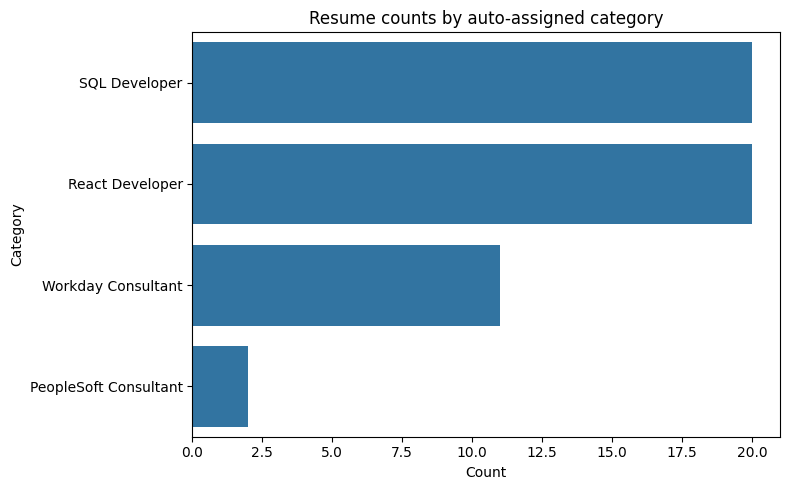

In [10]:
#Visual: category distribution
plt.figure(figsize=(8,5))
sns.countplot(y='label_auto', data=df, order=df['label_auto'].value_counts().index)
plt.title("Resume counts by auto-assigned category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


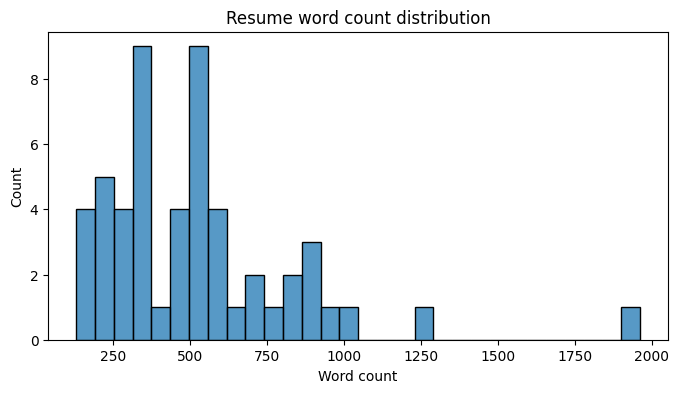

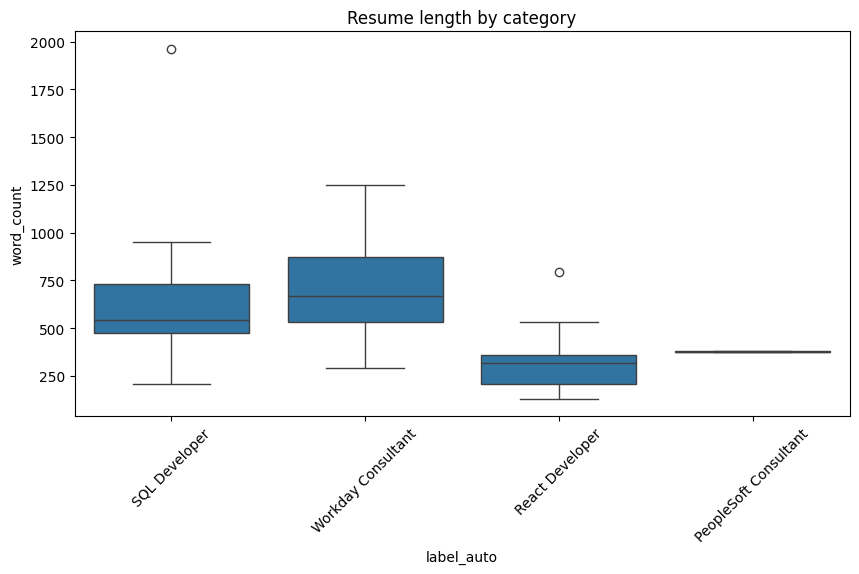

In [11]:
#Resume length distribution
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=False)
plt.title("Resume word count distribution")
plt.xlabel("Word count")
plt.show()

# boxplot by category
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='label_auto', y='word_count')
plt.xticks(rotation=45)
plt.title("Resume length by category")
plt.show()


In [12]:
# Top words overall and per category
def top_n_words(text_series, n=30):
    all_words = " ".join(text_series).split()
    counter = Counter(all_words)
    return counter.most_common(n)

print("Top 20 words overall:")
print(top_n_words(df['text_alpha'], 20))

# per category top 15
for cat in df['label_auto'].unique():
    text = " ".join(df[df['label_auto']==cat]['text_alpha'])
    print(f"\nTop words for {cat}:")
    print(top_n_words([text], 15))


Top 20 words overall:
[('and', 1399), ('the', 766), ('in', 707), ('to', 630), ('of', 508), ('on', 375), ('for', 360), ('experience', 313), ('using', 247), ('with', 227), ('as', 221), ('workday', 194), ('application', 187), ('a', 180), ('sql', 178), ('project', 177), ('from', 175), ('server', 169), ('data', 167), ('reports', 164)]

Top words for SQL Developer:
[('and', 714), ('in', 337), ('the', 337), ('of', 273), ('to', 258), ('sql', 173), ('server', 166), ('for', 159), ('on', 158), ('experience', 157), ('peoplesoft', 139), ('application', 111), ('using', 107), ('data', 103), ('as', 84)]

Top words for Workday Consultant:
[('and', 399), ('the', 208), ('in', 205), ('to', 205), ('workday', 174), ('on', 144), ('for', 109), ('of', 108), ('business', 96), ('reports', 86), ('as', 84), ('with', 80), ('experience', 80), ('integrations', 80), ('using', 68)]

Top words for React Developer:
[('and', 254), ('the', 185), ('in', 160), ('to', 131), ('of', 123), ('react', 119), ('js', 97), ('for', 82)

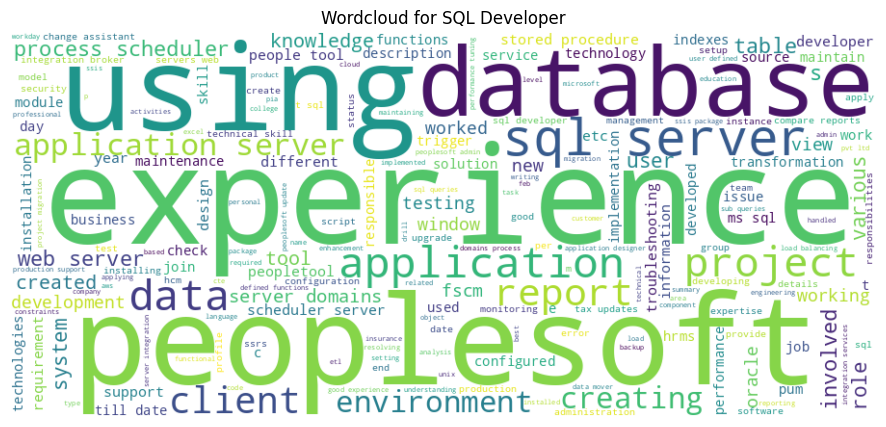

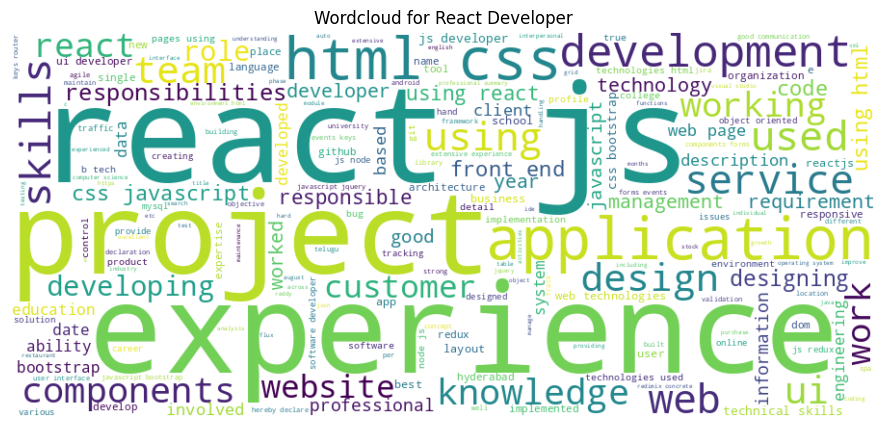

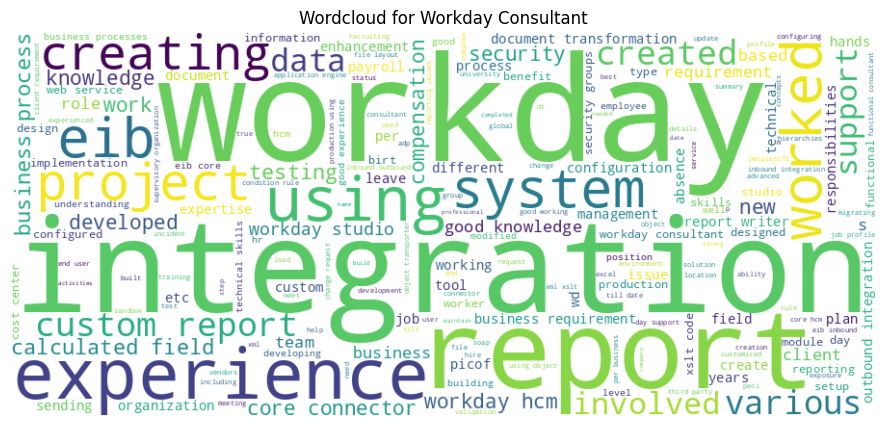

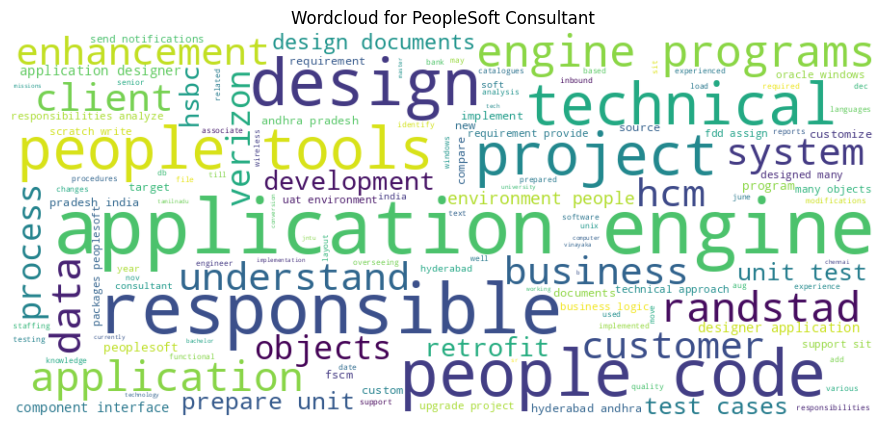

In [13]:
# Wordclouds per category (visual)
for cat in df['label_auto'].value_counts().index:
    text = " ".join(df[df['label_auto']==cat]['text_alpha'])
    if len(text.strip())==0:
        continue
    wc = WordCloud(width=900, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud for {cat}")
    plt.show()


In [14]:
#Keyword counts useful for debugging labels
keywords = ["react","redux","javascript","sql","ssis","ssrs","peoplesoft","workday","eib","fscm","hcm","app engine","peoplecode"]
for kw in keywords:
    df[f"kw_{kw}"] = df['text_alpha'].apply(lambda x: x.split().count(kw))
kw_counts = {kw: int(df[f"kw_{kw}"].sum()) for kw in keywords}
print("Keyword totals:", kw_counts)


Keyword totals: {'react': 119, 'redux': 22, 'javascript': 47, 'sql': 178, 'ssis': 28, 'ssrs': 14, 'peoplesoft': 156, 'workday': 194, 'eib': 62, 'fscm': 36, 'hcm': 78, 'app engine': 0, 'peoplecode': 2}


In [15]:
#Duplicate detection (exact cleaned text duplicates)
dups = df[df.duplicated('text_alpha', keep=False)].sort_values('label_auto')
print("Number of duplicate text entries:", len(dups))
if len(dups)>0:
    display(dups[['filename','label_auto','word_count']].head(20))


Number of duplicate text entries: 4


,filename,label_auto,word_count
27,React Dev_Krishna Kanth.docx,React Developer,530
28,React Dev_Krishna Kanth_Musquare Technologies....,React Developer,530
38,Reactjs Developer_M Lokesh Babu_Musquare Techn...,React Developer,305
39,Reactjs Developer_M Lokesh.docx,React Developer,305


In [16]:
#Manual label corrections (OPTIONAL)

print(df['label_auto'].value_counts())


label_auto
SQL Developer            20
React Developer          20
Workday Consultant       11
PeopleSoft Consultant     2
Name: count, dtype: int64


In [17]:
df['text_alpha']
df['label_auto']

,label_auto
0,SQL Developer
1,SQL Developer
2,SQL Developer
3,SQL Developer
4,Workday Consultant
5,Workday Consultant
6,Workday Consultant
7,React Developer
8,Workday Consultant
9,Workday Consultant


In [18]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
df['label_auto']=LE.fit_transform(df['label_auto'])
df['label_auto']


,label_auto
0,2
1,2
2,2
3,2
4,3
5,3
6,3
7,1
8,3
9,3


In [19]:
# splitting the Indepedent and Depedent Variable
from sklearn.model_selection import train_test_split
X=df['text_alpha']
Y=df['label_auto']

x_train,x_test,y_train,y_test=train_test_split(X,Y, test_size=0.2,random_state=42)

x_train


,text_alpha
8,jyoti verma years of experience in workday as ...
26,ramesh a workday hcm consultant professional s...
6,name ravali p curriculum vitae specialization ...
34,sri geethika prestige road number bandari layo...
4,name gopi krishna reddy professional summery w...
37,venkatalakshmi pedireddy software developer ex...
24,resume ramalakshmi k career objective professi...
44,shaik abdul sharuk years experience in wipro c...
33,pragnya pattnaik expertise having around years...
49,vinay kumar v workday functional consultant ex...


In [20]:
#TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

# quick sanity
print("TF-IDF shape:", X_train_tfidf.shape)

dic = {'tfidf': tfidf}


TF-IDF shape: (42, 5000)


In [21]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Modeling Step

In [22]:
# importing all the models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [23]:
all_models = pd.DataFrame(columns=['Model_name',"Accuracy"])
all_models

,Model_name,Accuracy


# Decision Tree Model

In [24]:
# Intializing the Decision Tree model
model=DecisionTreeClassifier(criterion='entropy',max_depth=4)

In [25]:
# providing the param grid values
import numpy as np
max_depth=np.arange(11)
criterion=['entropy','gini']
param_grid=dict(criterion=criterion,max_depth=max_depth)

In [26]:
# intializing the gridsearchcv
import warnings
warnings.filterwarnings('ignore')
grid=GridSearchCV(model,param_grid=param_grid)
grid.fit(X_train_tfidf,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=4),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [27]:
train_accuracy = grid.best_score_
print(grid.best_score_)
grid.best_params_

0.8166666666666668


{'criterion': 'entropy', 'max_depth': np.int64(4)}

In [28]:
# considering the best estimator as the model
model=grid.best_estimator_
model.fit(X_train_tfidf,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(4))

In [29]:
# predicting the target values
y_predict=model.predict(X_test_tfidf)

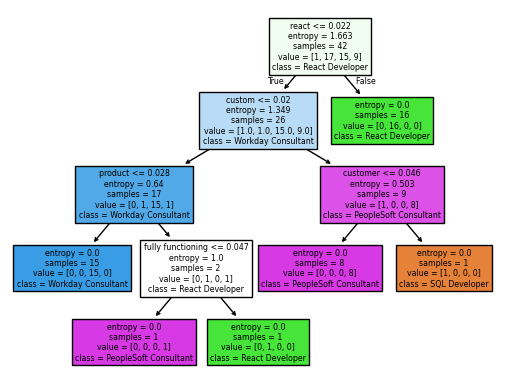

In [30]:
# plotting the decision tree
fn=tfidf.get_feature_names_out()
cn=['SQL Developer','React Developer','Workday Consultant','PeopleSoft Consultant']
tree.plot_tree(model,feature_names=fn,class_names=cn,filled=True);

In [31]:
import pandas as pd

# calculating the accuracy score,precision score,recall score and
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('Classification report')
print(classification_report(y_test,y_predict))

# Concatenate the new row to all_models
all_models.loc[0] = ['Decision Tree Classifier',accuracy_score(y_test,y_predict)]

Accuracy Score:0.8181818181818182
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.67      0.80         3
           2       0.80      0.80      0.80         5
           3       0.67      1.00      0.80         2

    accuracy                           0.82        11
   macro avg       0.87      0.87      0.85        11
weighted avg       0.85      0.82      0.82        11



In [32]:
conufus_mat = confusion_matrix(y_test,y_predict)

Text(0.5, 23.52222222222222, 'Confusion Matrix')

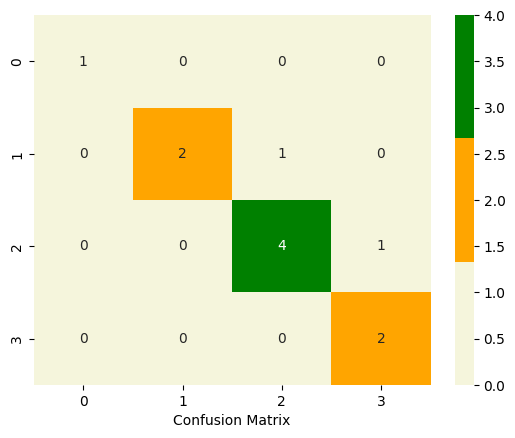

In [33]:
import seaborn as sns
sns.heatmap(conufus_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

# Random Forest Model

In [34]:
# intializng the randomforest model
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train_tfidf,y_train)

RandomForestClassifier()

In [35]:
# predicting the target variables
y_predict=model.predict(X_test_tfidf)

In [36]:
# calculating the accuracy score
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('classification report')
print(classification_report(y_test,y_predict))
all_models.loc[1] = ['Random Forest Classifier',accuracy_score(y_test,y_predict)]

Accuracy Score:0.9090909090909091
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.95      0.92        11
weighted avg       0.94      0.91      0.91        11



In [37]:
confusion_mat = confusion_matrix(y_test,y_predict)
print(confusion_mat)

[[1 0 0 0]
 [0 3 0 0]
 [0 0 4 1]
 [0 0 0 2]]


Text(0.5, 23.52222222222222, 'Confusion Matrix')

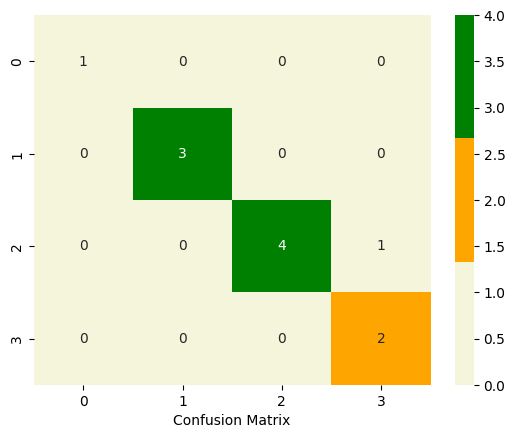

In [38]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

In [39]:
dic['model']= model
with open('model3.pkl','wb') as file:
  pickle.dump(dic,file)

# SVC model

In [40]:
# intializing the SVC
model=SVC(kernel='linear')

In [41]:
# providing the param grid value
c=[1,10,20,30,50]
kernel=['linear','rbf']
gamma=[5,10,15,20,25,'scale']
param_grid=dict(C=c,kernel=kernel,gamma=gamma)


In [42]:
# intializing the GridSearchCv
grid=GridSearchCV(model,param_grid=param_grid)
grid.fit(X_train_tfidf,y_train)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 10, 20, 30, 50],
                         'gamma': [5, 10, 15, 20, 25, 'scale'],
                         'kernel': ['linear', 'rbf']})

In [43]:
# Finding the best score and params
print(grid.best_score_)
print(grid.best_params_)

0.9555555555555555
{'C': 1, 'gamma': 5, 'kernel': 'linear'}


In [44]:
# considering the best estimator as model
model=grid.best_estimator_
model.fit(X_train_tfidf,y_train)

SVC(C=1, gamma=5, kernel='linear')

In [45]:
# calculating the target variable
y_predict=model.predict(X_test_tfidf)

In [46]:
# Calculating the accuracy score and classification report
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('Classification report')
print(classification_report(y_test,y_predict))
all_models.loc[2] = ['SVC', accuracy_score(y_test,y_predict)]

Accuracy Score:0.8181818181818182
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         3
           2       0.80      0.80      0.80         5
           3       0.67      1.00      0.80         2

    accuracy                           0.82        11
   macro avg       0.62      0.70      0.65        11
weighted avg       0.76      0.82      0.78        11



In [47]:
confusion_mat = confusion_matrix(y_test,y_predict)
print(confusion_mat)

[[0 0 1 0]
 [0 3 0 0]
 [0 0 4 1]
 [0 0 0 2]]


Text(0.5, 23.52222222222222, 'Confusion Matrix')

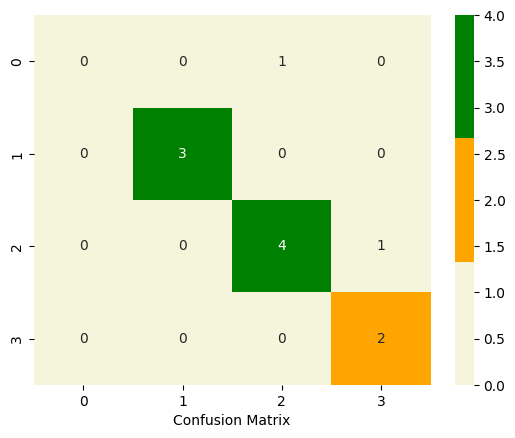

In [48]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

# KNeighbor Classifier Model

In [49]:
# intializing the KNeighborClassifier
model=KNeighborsClassifier(n_neighbors=10)

In [50]:
# provdeing the param grid values
n_neighbors=np.arange(11)
param_grid=dict(n_neighbors=n_neighbors)

In [51]:
# intializing the gridsearchCv
grid=GridSearchCV(model,param_grid=param_grid)
grid.fit(X_train_tfidf,y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [52]:
# finding the best score and best paramas
print(grid.best_score_)
print(grid.best_params_)

0.9555555555555555
{'n_neighbors': np.int64(1)}


In [53]:
# Considering the best estimator as model
model=grid.best_estimator_
model.fit(X_train_tfidf,y_train)

KNeighborsClassifier(n_neighbors=np.int64(1))

In [54]:
# Calculating the target variable
y_predict=model.predict(X_test_tfidf)

In [55]:
# Calculating the accuracy score and classification report
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('Classification Report')
print(classification_report(y_test,y_predict))
all_models.loc[3] = ['KNeighbor Classifier', accuracy_score(y_test,y_predict)]

Accuracy Score:0.9090909090909091
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.95      0.92        11
weighted avg       0.94      0.91      0.91        11



In [56]:
confusion_mat = confusion_matrix(y_test,y_predict)
print(confusion_mat)

[[1 0 0 0]
 [0 3 0 0]
 [0 0 4 1]
 [0 0 0 2]]


Text(0.5, 23.52222222222222, 'Confusion Matrix')

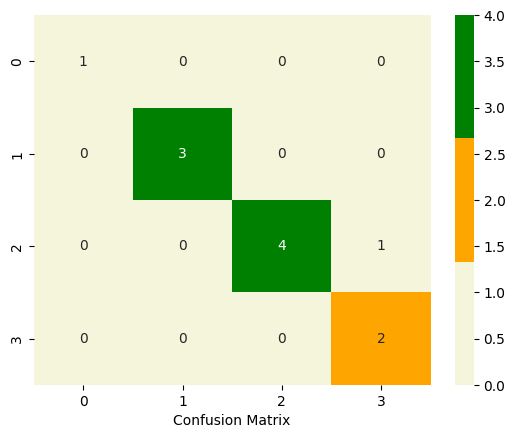

In [57]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

# Gradient Boosting Classifier model

In [58]:
# Intializing the GradientBoostingClassifier
gbc=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)
gbc.fit(X_train_tfidf,y_train)

GradientBoostingClassifier()

In [59]:
# predicting the target variable
y_predict=gbc.predict(X_test_tfidf)

In [60]:
# Calculating the accuracy score and classification report
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('Classification report')
print(classification_report(y_test,y_predict))
all_models.loc[4] = ['Gradeint Boosting Classifier', accuracy_score(y_test,y_predict)]

Accuracy Score:0.8181818181818182
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.67      0.80         3
           2       0.80      0.80      0.80         5
           3       0.67      1.00      0.80         2

    accuracy                           0.82        11
   macro avg       0.87      0.87      0.85        11
weighted avg       0.85      0.82      0.82        11



In [61]:
confusion_mat = confusion_matrix(y_test,y_predict)
print(confusion_mat)

[[1 0 0 0]
 [0 2 1 0]
 [0 0 4 1]
 [0 0 0 2]]


Text(0.5, 23.52222222222222, 'Confusion Matrix')

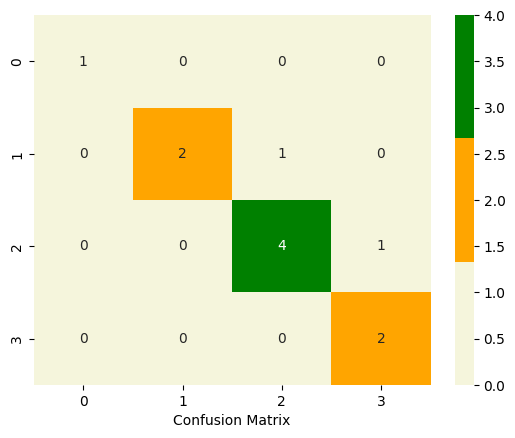

In [62]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

# XGBoost Classifier Model

In [63]:
!pip install --upgrade scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [64]:
# importing the xgboost algorithm
from xgboost import XGBClassifier

In [65]:
# intializing the xgboost algorithm
xgb=XGBClassifier(n_estimators=100,learning_rate=0.1,colsample_bytree=0.8,max_depth=7)
xgb.fit(X_train_tfidf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [66]:
# predicting the target values for the test data
y_predict=xgb.predict(X_test_tfidf)

In [67]:
# Calculating the accuracy score
print(f'Accuracy Score:{accuracy_score(y_test,y_predict)}')
print('Classification report')
print(classification_report(y_test,y_predict))
all_models.loc[5] = ["XGBoosting Classifier", accuracy_score(y_test,y_predict)]

Accuracy Score:0.8181818181818182
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.67      0.80         3
           2       0.80      0.80      0.80         5
           3       0.67      1.00      0.80         2

    accuracy                           0.82        11
   macro avg       0.87      0.87      0.85        11
weighted avg       0.85      0.82      0.82        11



In [68]:
confusion_mat = confusion_matrix(y_test,y_predict)
print(confusion_mat)

[[1 0 0 0]
 [0 2 1 0]
 [0 0 4 1]
 [0 0 0 2]]


Text(0.5, 23.52222222222222, 'Confusion Matrix')

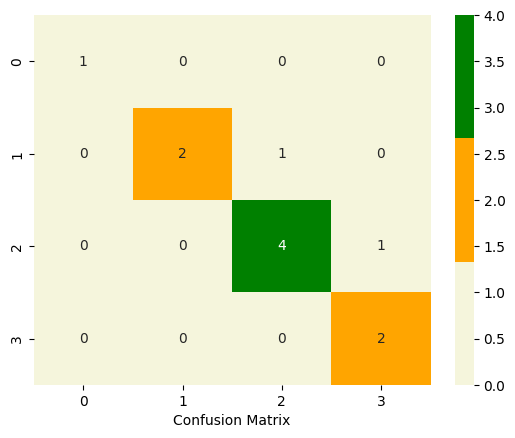

In [69]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap=['Beige','orange','green'],annot=True);
plt.xlabel('Confusion Matrix')

In [70]:
# all models in a data frame with accuracy and model name
all_models

,Model_name,Accuracy
0,Decision Tree Classifier,0.818182
1,Random Forest Classifier,0.909091
2,SVC,0.818182
3,KNeighbor Classifier,0.909091
4,Gradeint Boosting Classifier,0.818182
5,XGBoosting Classifier,0.818182
